In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
import os
import numpy as np
from PIL import Image

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:

class SegmentationDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.img_transform = transforms.Compose([
            transforms.Resize((512, 1024)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((512, 1024), interpolation=Image.NEAREST)
        ])
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        print(f"Found {len(self.images)} images in {data_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name)
        mask_name = img_name.replace(".jpg","_mask.png")
        mask_path = os.path.join(self.data_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        mask = np.array(mask)
        mask = torch.from_numpy(mask)

        return image, mask.squeeze().long()

In [4]:
train_dataset = SegmentationDataset("../teethSegSet/trainSet/")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

test_dataset = SegmentationDataset("../teethSegSet/testSet/")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

Found 589 images in ../teethSegSet/trainSet/
Found 9 images in ../teethSegSet/testSet/


In [5]:
model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
num_classes = 2
in_channels = model.classifier[-1].in_channels
aux_in_channels = model.aux_classifier[-1].in_channels

model.classifier[-1] = nn.Conv2d(
    in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)
model.aux_classifier[-1] = nn.Conv2d(
    aux_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)

model = model.to(device)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].


Image shape: (512, 1024, 3), Image dtype: float64


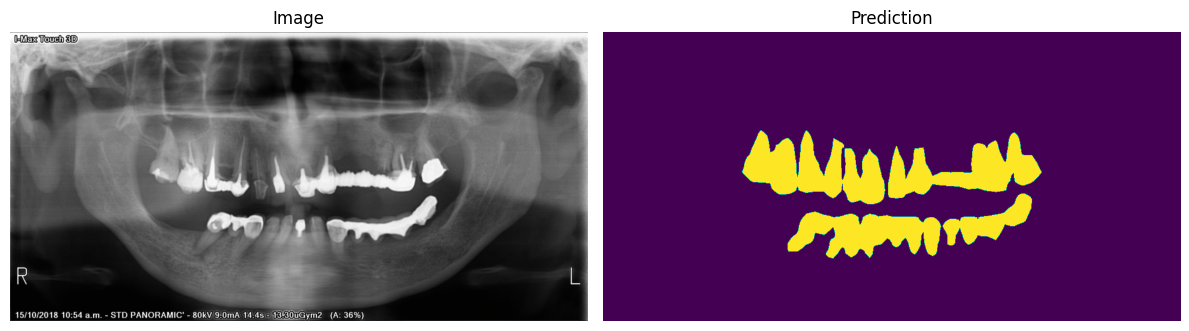

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np


state_dict = torch.load('./teethSegModel.pth', map_location=device)
model.load_state_dict(state_dict)



def visulize_segmentation( model, test_loader, deivce ):
    model.eval()
    img, _ = next(iter(test_loader))
    img = img.to(device)

    with torch.no_grad():
        out = model(img)['out'] 
        pred = out.argmax(dim=1)
        pred = pred.cpu().numpy().squeeze()

    img_np = img.cpu().numpy().squeeze()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std[:, None, None ] * img_np + mean[:, None, None]
    img_np = np.transpose(img_np, (1, 2, 0))
    print(f"Image shape: {img_np.shape}, Image dtype: {img_np.dtype}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img_np)
    ax1.set_title("Image")
    ax1.axis('off')

    ax2.imshow(pred*255)
    ax2.set_title("Prediction")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

visulize_segmentation(model, test_loader, device)